In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
!pip install kagglehub tensorflow numpy matplotlib scikit-learn shap lime opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8461cd87e0c09c1981a3a99efe4f79558edad1278617533843029e06934e4ef1
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
import os, time, random, shutil, gc
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import kagglehub
import shap
import lime
import lime.lime_image
import cv2


In [ ]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("✅ Dataset downloaded at:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
✅ Dataset downloaded at: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
# The dataset has train/valid/test folders
train_dir = os.path.join(path, "Training")
test_dir = os.path.join(path, "Testing")

In [ ]:
# 🧹 DATA PREPROCESSING

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_data = datagen.flow_from_directory(
    train_dir, target_size=(128,128),
    batch_size=32, class_mode='categorical', subset='training'
)

val_data = datagen.flow_from_directory(
    train_dir, target_size=(128,128),
    batch_size=32, class_mode='categorical', subset='validation'
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=(128,128),
    batch_size=32, class_mode='categorical'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [12]:
def create_cnn_model(lr=0.001, dropout=0.3, filters=32, conv_layers=2):
    model = models.Sequential()
    model.add(layers.Input(shape=(128,128,3)))
    model.add(layers.Conv2D(filters, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))

    for _ in range(conv_layers - 1):
        model.add(layers.Conv2D(filters * 2, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [10]:
baseline_model = create_cnn_model()
history = baseline_model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3657 - loss: 1.6518 - val_accuracy: 0.2500 - val_loss: 1.3891
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 681ms/step - accuracy: 0.5366 - loss: 1.2215 - val_accuracy: 0.3438 - val_loss: 1.2731
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 692ms/step - accuracy: 0.6405 - loss: 0.9314 - val_accuracy: 0.5000 - val_loss: 1.2214
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7905 - loss: 0.5890 - val_accuracy: 0.5938 - val_loss: 1.2851
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 685ms/step - accuracy: 0.8785 - loss: 0.3448 - val_accuracy: 0.5938 - val_loss: 1.4395


In [11]:
base_loss, base_acc = baseline_model.evaluate(test_data)
print(f"Baseline Accuracy: {base_acc*100:.2f}% | Loss: {base_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6699 - loss: 1.4759 
Baseline Accuracy: 69.23% | Loss: 1.3943


# ***`Phase 1`***

In [ ]:
# ⚙ METAHEURISTIC OPTIMIZATION SETUP


def evaluate_params(params):
    lr, dropout, filters, conv_layers, batch_size = params
    model = create_cnn_model(
        lr=float(lr),
        dropout=float(dropout),
        filters=int(filters),
        conv_layers=int(conv_layers)
    )

    hist = model.fit(
        train_data,
        validation_data=val_data,
        epochs=2,  # fast evaluation
        batch_size=int(batch_size),
        verbose=0
    )

    return hist.history['val_accuracy'][-1]

In [ ]:
def GA(pop=4, gens=3):
    population = [
        [
            random.uniform(1e-4, 1e-3),        # lr
            random.uniform(0.2, 0.5),          # dropout
            random.choice([16, 32, 64]),       # filters
            random.choice([1, 2, 3]),          # conv_layers
            random.choice([16, 32, 64])        # batch_size
        ]
        for _ in range(pop)
    ]

    best_p, best_s = population[0], 0

    for _ in range(gens):
        scores = [evaluate_params(p) for p in population]
        idx = np.argmax(scores)

        if scores[idx] > best_s:
            best_s = scores[idx]
            best_p = population[idx]

        new_population = []
        for _ in range(pop):
            p1 = population[random.randrange(pop)]
            p2 = population[random.randrange(pop)]

            child = [(p1[j] + p2[j]) / 2 for j in range(5)]

            child[0] *= random.uniform(0.8, 1.2)  # mutation on lr

            new_population.append(child)

        population = new_population

    return best_p, best_s


In [ ]:
#  Particle Swarm Optimization (PSO)

def PSO(num_particles=4, iterations=3):
    particles = [np.array([
        random.uniform(1e-4, 1e-3),          # lr
        random.uniform(0.2, 0.5),            # dropout
        random.choice([16, 32, 64]),         # filters
        random.choice([1, 2, 3]),            # conv layers
        random.choice([16, 32, 64])          # batch size
    ]) for _ in range(num_particles)]

    velocities = [np.zeros(5) for _ in range(num_particles)]
    best_global = particles[0]
    best_global_score = 0

    for it in range(iterations):
        for i, p in enumerate(particles):
            acc = evaluate_params(p)
            if acc > best_global_score:
                best_global_score = acc
                best_global = p
            velocities[i] = 0.5 * velocities[i] + 0.5 * (best_global - p)
            particles[i] += velocities[i]
    return best_global, best_global_score

In [ ]:
# Simulated Annealing (SA)


def SA(iterations=5, T=1.0, alpha=0.8):
    current = np.array([0.001, 0.3, 32, 2, 32])
    current_score = evaluate_params(current)
    best, best_score = current.copy(), current_score

    for i in range(iterations):
        new = current + np.random.uniform(-0.0003, 0.0003, 5)
        new[2] = random.choice([16, 32, 64])    # filters
        new[3] = random.choice([1, 2, 3])       # conv layers
        new[4] = random.choice([16, 32, 64])    # batch size
        new_score = evaluate_params(new)

        if new_score > current_score or np.exp((new_score - current_score) / T) > random.random():
            current, current_score = new, new_score

        if new_score > best_score:
            best, best_score = new, new_score

        T *= alpha
    return best, best_score


In [ ]:
# Tabu Search

def TABU(iterations=5, tabu_size=3):
    current = np.array([0.001, 0.3, 32, 2, 32])
    best, best_score = current.copy(), evaluate_params(current)
    tabu_list = []

    for _ in range(iterations):
        neighbors = [
            current + np.random.uniform(-0.0002, 0.0002, 5)
            for _ in range(3)
        ]
        for n in neighbors:
            n[2] = random.choice([16, 32, 64])
            n[3] = random.choice([1, 2, 3])
            n[4] = random.choice([16, 32, 64])

        candidates = [
            (n, evaluate_params(n))
            for n in neighbors if list(n) not in tabu_list
        ]

        if not candidates:
            continue
        candidates.sort(key=lambda x: x[1], reverse=True)
        best_neighbor, best_neighbor_score = candidates[0]

        if best_neighbor_score > best_score:
            best, best_score = best_neighbor, best_neighbor_score

        current = best_neighbor
        tabu_list.append(list(current))
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)

    return best, best_score

In [ ]:
results = {
    "GA": GA(),
    "PSO": PSO(),
    "SA": SA(),
    "TABU": TABU()
}

def unpack(p):
    return {
        "Learning Rate": p[0],
        "Dropout": p[1],
        "Filters": int(p[2]),
        "Conv Layers": int(p[3]),
        "Batch Size": int(p[4])
    }

df_phase1 = pd.DataFrame([
    {"Algorithm": k, **unpack(v[0]), "Val Acc": v[1]}
    for k, v in results.items()
])

df_phase1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


,Algorithm,Learning Rate,Dropout,Filters,Conv Layers,Batch Size,Val Acc
0,GA,0.000417,0.354732,32,2,64,0.56250
1,PSO,0.000595,0.415414,32,3,64,0.50000
2,SA,0.000474,0.295947,16,3,32,0.46875
3,TABU,0.000415,0.288572,32,2,32,0.53125


In [ ]:
best_row = df_phase1.loc[df_phase1["Val Acc"].idxmax()]

BEST_LR = best_row["Learning Rate"]
BEST_DROPOUT = best_row["Dropout"]
BEST_FILTERS = int(best_row["Filters"])
BEST_CONV_LAYERS = int(best_row["Conv Layers"])
BEST_BATCH = int(best_row["Batch Size"])

print("BEST CONFIG FROM PHASE 1")
print(best_row)


BEST CONFIG FROM PHASE 1
Algorithm              GA
Learning Rate    0.000417
Dropout          0.354732
Filters                32
Conv Layers             2
Batch Size             64
Val Acc            0.5625
Name: 0, dtype: object


# ***`Phase 2`***

In [ ]:
def build_phase2_model(dropout=0.3, neurons=64):
    model = Sequential([
        Conv2D(16, 3, activation='relu', input_shape=(128,128,3)),
        MaxPooling2D(2),
        Flatten(),
        Dense(int(neurons), activation='relu'),
        Dropout(dropout),
        Dense(len(classes), activation='softmax')
    ])
    return model


In [ ]:
def evaluate_phase2(lr, dropout, neurons, epochs=1):
    K.clear_session()
    gc.collect()

    model = build_phase2_model(dropout, neurons)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    hist = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        verbose=0
    )

    acc = hist.history["val_accuracy"][-1]

    del model
    K.clear_session()
    gc.collect()

    return acc

In [ ]:
bounds = [
    (1e-4, 1e-3),   # learning rate
    (0.2, 0.5),     # dropout
    (32, 128)       # neurons
]

def decode(vec):
    lr = bounds[0][0] + vec[0] * (bounds[0][1] - bounds[0][0])
    dr = bounds[1][0] + vec[1] * (bounds[1][1] - bounds[1][0])
    ne = bounds[2][0] + vec[2] * (bounds[2][1] - bounds[2][0])
    return lr, dr, int(ne)

In [ ]:
def cuckoo_search(alpha, n_nests=3, iters=2, pa=0.25):
    dim = 3
    nests = np.random.rand(n_nests, dim)
    fitness = np.zeros(n_nests)

    # Initial fitness
    for i in range(n_nests):
        lr, dr, ne = decode(nests[i])
        fitness[i] = evaluate_phase2(lr, dr, ne)

    best_idx = np.argmax(fitness)
    best_nest = nests[best_idx].copy()
    best_score = fitness[best_idx]

    for _ in range(iters):
        for i in range(n_nests):
            # Levy flight
            step = alpha * np.random.standard_cauchy(dim)
            candidate = np.clip(nests[i] + step, 0, 1)

            lr, dr, ne = decode(candidate)
            score = evaluate_phase2(lr, dr, ne)

            if score > fitness[i]:
                nests[i] = candidate
                fitness[i] = score

        # Abandon worst nests
        for i in range(n_nests):
            if random.random() < pa:
                nests[i] = np.random.rand(dim)
                lr, dr, ne = decode(nests[i])
                fitness[i] = evaluate_phase2(lr, dr, ne)

        best_idx = np.argmax(fitness)
        if fitness[best_idx] > best_score:
            best_score = fitness[best_idx]
            best_nest = nests[best_idx].copy()

    return decode(best_nest), best_score

In [ ]:
def bat_optimize_alpha(
    alpha_bounds=(0.01, 0.3),
    n_bats=4,
    iters=3,
    fmin=0.0,
    fmax=2.0,
    A=0.9,
    r=0.5
):
    bats = np.random.uniform(*alpha_bounds, n_bats)
    velocity = np.zeros(n_bats)
    fitness = np.zeros(n_bats)

    for i in range(n_bats):
        _, fitness[i] = cuckoo_search(bats[i])

    best_idx = np.argmax(fitness)
    best_alpha = bats[best_idx]
    best_score = fitness[best_idx]

    for _ in range(iters):
        for i in range(n_bats):
            beta = random.random()
            freq = fmin + (fmax - fmin) * beta

            velocity[i] += (bats[i] - best_alpha) * freq
            candidate = bats[i] + velocity[i]
            candidate = np.clip(candidate, *alpha_bounds)

            # Local random walk
            if random.random() > r:
                candidate = best_alpha + 0.01 * np.random.randn()

            _, score = cuckoo_search(candidate)

            if score > fitness[i] and random.random() < A:
                bats[i] = candidate
                fitness[i] = score

            if score > best_score:
                best_alpha = candidate
                best_score = score

    best_params, _ = cuckoo_search(best_alpha)
    return best_alpha, best_params, best_score

In [ ]:
def firefly(alpha, n_fireflies=4, iters=3, beta0=1.0, gamma=1.0):
    dim = 3
    pop = np.random.rand(n_fireflies, dim)
    fitness = np.zeros(n_fireflies)

    for i in range(n_fireflies):
        lr, dr, ne = decode(pop[i])
        fitness[i] = evaluate_phase2(lr, dr, ne)

    for _ in range(iters):
        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if fitness[j] > fitness[i]:
                    r = np.linalg.norm(pop[i] - pop[j])
                    beta = beta0 * np.exp(-gamma * r * r)
                    step = alpha * (np.random.rand(dim) - 0.5)

                    candidate = pop[i] + beta * (pop[j] - pop[i]) + step
                    candidate = np.clip(candidate, 0, 1)

                    lr, dr, ne = decode(candidate)
                    score = evaluate_phase2(lr, dr, ne)

                    if score > fitness[i]:
                        pop[i] = candidate
                        fitness[i] = score

    best_idx = np.argmax(fitness)
    return decode(pop[best_idx]), fitness[best_idx]

In [ ]:
def gwo_optimize_alpha(alpha_bounds=(0.05, 0.5), n_wolves=4, iters=3):
    wolves = np.random.uniform(*alpha_bounds, n_wolves)
    scores = np.zeros(n_wolves)

    for i in range(n_wolves):
        _, scores[i] = firefly(wolves[i])

    for t in range(iters):
        a = 2 - 2 * (t / iters)

        idx = np.argsort(-scores)
        alpha, beta, delta = wolves[idx[0]], wolves[idx[1]], wolves[idx[2]]

        for i in range(n_wolves):
            r1, r2 = random.random(), random.random()
            A1 = 2 * a * r1 - a
            C1 = 2 * r2

            D_alpha = abs(C1 * alpha - wolves[i])
            X1 = alpha - A1 * D_alpha

            wolves[i] = np.clip(X1, *alpha_bounds)

            _, score = firefly(wolves[i])
            scores[i] = score

    best = np.argmax(scores)
    best_params, _ = firefly(wolves[best])
    return wolves[best], best_params, scores[best]

In [ ]:
best_alpha_csa, best_acc_csa = bat_optimize_alpha()
print("BAT ⟶ CSA | best alpha:", best_alpha_csa, "| val acc:", best_acc_csa)

best_alpha_ff, best_acc_ff = gwo_optimize_alpha()
print("GWO ⟶ Firefly | best alpha:", best_alpha_ff, "| val acc:", best_acc_ff)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


BAT ⟶ CSA | best alpha: 0.1804732013404307 | val acc: 0.5
GWO ⟶ Firefly | best alpha: 0.48479330707037904 | val acc: 0.46875


In [15]:
def compare_and_update_best():
    global BEST_LR, BEST_DROPOUT, BEST_FILTERS, BEST_CONV_LAYERS

    print("\n===== PHASE 2 INTERNAL COMPARISON =====")

    # Compare Phase 2 algorithms
    print(f"BAT ⟶ CSA  | Val Acc : {best_acc_csa}")
    print(f"GWO ⟶ Firefly | Val Acc : {best_acc_ff}")

    if best_acc_csa >= best_acc_ff:
        best_phase2_acc = best_acc_csa
        best_phase2_source = "BAT ⟶ CSA"
    else:
        best_phase2_acc = best_acc_ff
        best_phase2_source = "GWO ⟶ Firefly"

    print(f"\nBest Phase 2 Algorithm : {best_phase2_source}")
    print(f"Best Phase 2 Accuracy  : {best_phase2_acc}")

    # Compare Phase 2 with Phase 1
    print("\n===== FINAL COMPARISON =====")
    print(f"Phase 1 Val Acc : {best_row['Val Acc']}")
    print(f"Phase 2 Val Acc : {best_phase2_acc}")

    if best_row["Val Acc"] >= best_phase2_acc:
        print("\nPhase 1 is better")
        print("→ Keeping Phase 1 parameters")
    else:
        print("\nPhase 2 is better")
        print("→ Updating BEST parameters using Phase 2")

        BEST_LR = BEST_LR
        BEST_DROPOUT = BEST_DROPOUT
        BEST_FILTERS = BEST_FILTERS
        BEST_CONV_LAYERS = BEST_CONV_LAYERS



===== PHASE 2 INTERNAL COMPARISON =====
BAT ⟶ CSA  | Val Acc : 0.5
GWO ⟶ Firefly | Val Acc : 0.46875

Best Phase 2 Algorithm : BAT ⟶ CSA
Best Phase 2 Accuracy  : 0.5

===== FINAL COMPARISON =====
Phase 1 Val Acc : 0.5625
Phase 2 Val Acc : 0.5

Phase 1 is better
→ Keeping Phase 1 parameters


# ***`XAI`***

In [ ]:
final_model = create_cnn_model(
    lr=BEST_LR,
    dropout=BEST_DROPOUT,
    filters=BEST_FILTERS,
    conv_layers=BEST_CONV_LAYERS
)

final_model.fit(
    train_data,
    validation_data=val_data,
    epochs=3,
    batch_size=BEST_BATCH,
    verbose=1
)


Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 737ms/step - accuracy: 0.3216 - loss: 1.6066 - val_accuracy: 0.2812 - val_loss: 1.4932
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - accuracy: 0.4623 - loss: 1.1919 - val_accuracy: 0.4062 - val_loss: 1.2241
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - accuracy: 0.6976 - loss: 0.9308 - val_accuracy: 0.4062 - val_loss: 1.2454


In [ ]:
x_batch, _ = next(val_data)
xai_images = x_batch[:3]


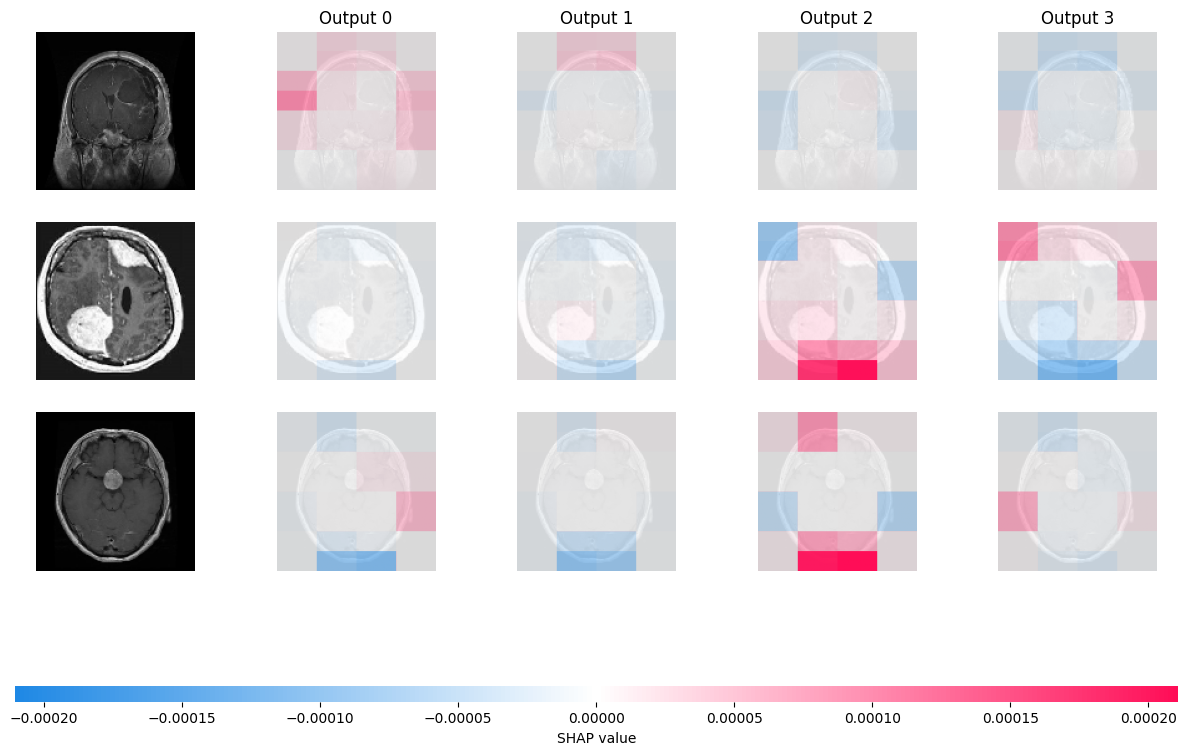

In [ ]:
def shap_predict(x):
    return final_model.predict(x, verbose=0)

masker = shap.maskers.Image("blur(64,64)", (128,128,3))
explainer = shap.Explainer(shap_predict, masker)

shap_values = explainer(
    xai_images,
    max_evals=200,
    batch_size=16
)

shap.image_plot(shap_values, xai_images)


  0%|          | 0/500 [00:00<?, ?it/s]

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

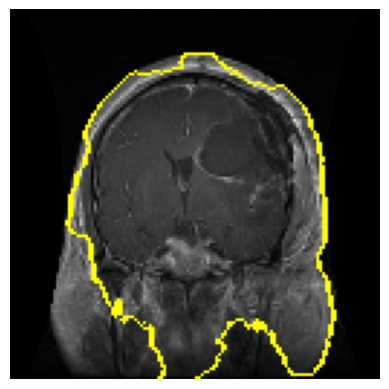

In [ ]:
from skimage.segmentation import mark_boundaries

lime_explainer = lime.lime_image.LimeImageExplainer()

def lime_predict(x):
    return final_model.predict(x, verbose=0)

explanation = lime_explainer.explain_instance(
    xai_images[0],
    lime_predict,
    top_labels=1,
    num_samples=500
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")
